In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice

from numba import jit
import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
import energy
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Visualization

In [3]:
sim_path = '../data/sims/'
energies = pd.read_csv(os.path.join(sim_path,'energiessize.csv'), index_col='size')
sizes = energies.index.to_list()

In [4]:
gse = []
for size in sizes:
    gs = pd.read_csv(f'../data/states/af4/{size}.csv', index_col='id')
    sel_particles = aux.get_positions_from_ctrj(gs).to_numpy()
    gs_energy = energy.calculate_energy(params['freedom'],size*params['lattice_constant'].magnitude,sel_particles)
    gse.append(gs_energy)


In [5]:
energies

,0,1,2,3,4,5,6,7,8,9
size,,,,,,,,,,
10,-4.080110e+05,-4.048835e+05,-4.064367e+05,-4.034978e+05,-4.077740e+05,-4.053030e+05,-4.067845e+05,-4.083347e+05,-4.085419e+05,-4.018400e+05
12,-5.957535e+05,-5.945571e+05,-5.894080e+05,-5.914157e+05,-5.885268e+05,-5.928404e+05,-5.906389e+05,-5.899752e+05,-5.921465e+05,-5.910536e+05
14,-8.132140e+05,-8.134376e+05,-8.083577e+05,-8.139550e+05,-8.085199e+05,-8.110923e+05,-8.094632e+05,-8.101603e+05,-8.091481e+05,-8.095964e+05
16,-1.063126e+06,-1.057487e+06,-1.064862e+06,-1.066885e+06,-1.068094e+06,-1.065948e+06,-1.064388e+06,-1.062948e+06,-1.063031e+06,-1.064098e+06
18,-1.350081e+06,-1.354327e+06,-1.347783e+06,-1.352028e+06,-1.349606e+06,-1.354611e+06,-1.355319e+06,-1.348923e+06,-1.359765e+06,-1.349441e+06
20,-1.678196e+06,-1.674367e+06,-1.667049e+06,-1.677004e+06,-1.678748e+06,-1.670727e+06,-1.680718e+06,-1.671159e+06,-1.679499e+06,-1.681300e+06
22,-2.034328e+06,-2.035277e+06,-2.038580e+06,-2.031275e+06,-2.034452e+06,-2.036139e+06,-2.035534e+06,-2.026015e+06,-2.021753e+06,-2.036269e+06
24,-2.421885e+06,-2.423298e+06,-2.419782e+06,-2.434234e+06,-2.429039e+06,-2.425845e+06,-2.436126e+06,-2.424410e+06,-2.428424e+06,-2.429165e+06
26,-2.844180e+06,-2.847643e+06,-2.854117e+06,-2.859103e+06,-2.853104e+06,-2.854138e+06,-2.842787e+06,-2.858478e+06,-2.864429e+06,-2.860794e+06


In [6]:
dE = energies.dropna(axis=1).to_numpy() - np.array(gse).reshape(-1,1)
dEav = dE.mean(axis=1)
dEstd = dE.std(axis=1)
eta = dEav / params['kbT'].magnitude / aux.bint(sizes)**2
std = dEstd / params['kbT'].magnitude / aux.bint(sizes)**2

In [39]:
from sklearn.linear_model import LinearRegression

x = np.array(sizes).reshape(-1,1)
y = eta.copy()

model = LinearRegression()
model.fit(x,y)

predicted = model.predict(x)

In [83]:
model_label = r'$ \mathbf{slope\sim 10^{-5}}$ '
model_label

'$ \\mathbf{slope\\sim 10^{-5}}$ '

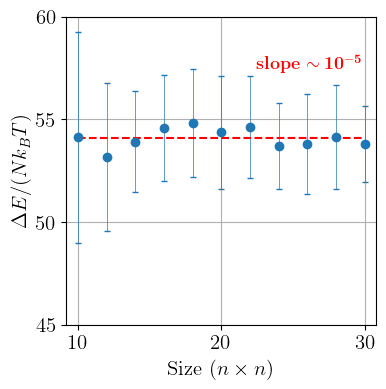

In [94]:
fig, ax = plt.subplots( figsize = (4,4))

ax.errorbar(sizes,eta,yerr=std, fmt='o',capsize=2,elinewidth=0.5)
ax.plot(x,predicted,'--',c='r')
ax.set_ylim(45,60)
ax.set_xticks(sizes)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(list(range(10,30+1,10)))
ax.set_yticks(list(range(45,61,5)))
ax.margins(0.04,0)
ax.grid()

ax.set_xlabel('Size $(n\\times n)$', fontsize=15)
ax.set_ylabel(' $\\Delta E / (Nk_BT)$', fontsize=15)

fig.text(0.6,0.75,model_label,c='r',fontsize=13)

plt.show()

fig.savefig('../data/figs/fig4c.png', dpi=300,bbox_inches='tight')
fig.savefig('../data/figs/fig4c.pdf')

In [26]:
sizes

[10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]